# Minority rule in Stargaze

In [11]:
import json
from typing import List
import requests
from funcy import compose, sums
import pandas as pd
from jupyterthemes import jtplot

Get the state of all validators.

In [12]:
def voting_powers (validators: List) -> List[int]:
    tokens = [int(v['voting_power']) for v in validators]
    return tokens

# assert(len(voting_powers(validators(stargaze_rpc)))>1)

In [13]:
def values_to_marketshares (values: List[int]) -> List[float]:
    '''
    Takes value of each firm and turns it into a proportion, i.e., 
    their share of the total market.
    '''
    total = sum(values)
    return [v / total for v in values ]

assert(values_to_marketshares([10, 10, 30]) == [0.2, 0.2, 0.6])

Get the delegation associated with each validator.

In [14]:
def percentage_who_could_pass(marketshares, majority=0.5):
    powers = list(sums(marketshares))
    for i, power in enumerate(powers):
        if power > majority:
            return i / len(powers)
    return

# percentage_who_could_pass(marketshares)

In [15]:
def validators (rpc):
    return requests.get(f'{rpc}/validators').json()['result']['validators']

stargaze_rpc = 'http://173.255.240.182:26657'
minority_rule = compose(percentage_who_could_pass, values_to_marketshares, voting_powers, validators)
minority_rule(stargaze_rpc)

0.23333333333333334

## Compare to other networks

In [16]:
from time import time
# oasis
def minority_smartstake (url):
    validators = requests.get(url).json()['data']
    values = [v['totalShares'] for v in validators]
    return percentage_who_could_pass(values_to_marketshares(values))

minority_smartstake(f'https://oprod.smartstakeapi.com/listData?type=oasisPools&selectedInd=True&key=2mwTEDr9zXJH323M&token={int(time())}&app=OASIS')

0.16216216216216217

In [21]:
minority_rules = {
    'Stargaze': minority_rule(stargaze_rpc),
    'Juno': minority_rule('https://rpc-juno.itastakers.com'),
    'Cosmos Hub': minority_rule('https://cosmoshub.validator.network:443'),
    'Osmosis': minority_rule('https://rpc-osmosis.keplr.app'),
    'Akash': minority_rule('https://rpc-akash.keplr.app'),
    'Regen':  minority_rule('https://rpc-regen.keplr.app'),
    'Sentinel': minority_rule('https://rpc-sentinel.keplr.app'),
    'Oasis': minority_smartstake(f'https://oprod.smartstakeapi.com/listData?type=oasisPools&selectedInd=True&key=2mwTEDr9zXJH323M&token={int(time())}&app=OASIS'),
    'Terra': minority_smartstake(f'https://ucyy8jicu2.execute-api.us-east-1.amazonaws.com/prod/listData?type=listPools&status=Bonded&key=2mwTEDr9zXJH323M&token={int(time())}&app=TERRA')
}

Text(0, 0.5, '% of validators that could pass a proposal')

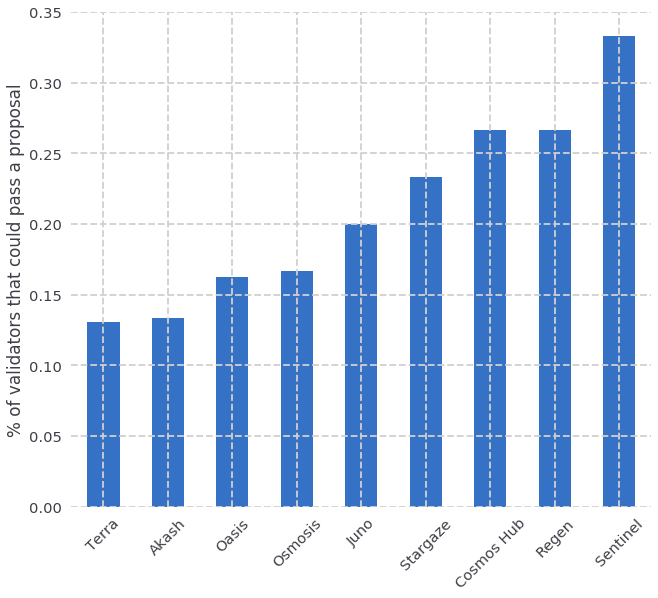

In [22]:
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

ax = pd.Series(minority_rules).sort_values().plot.bar(rot=45)
ax.set_ylabel('% of validators that could pass a proposal')

In [23]:
minority_rules['Terra']

0.13076923076923078

# Correlations with HHI

In [27]:
def hhi (marketshares: List[float]):
    '''
    "The HHI is calculated by squaring the market share of each firm competing in the market 
    and then summing the resulting numbers."
    
    U.S. federal agencies "generally consider markets in which the HHI is between 
    1,500 and 2,500 points to be moderately concentrated, and consider markets 
    in which the HHI is in excess of 2,500 points to be highly concentrated."
    
    From https://www.justice.gov/atr/herfindahl-hirschman-index
    '''
    squares = [(x*100)*(x*100) for x in marketshares]
    return sum(squares)
    
assert(hhi([.30, .30, .20, .20]) == 2600)

In [29]:
# oasis
def hhi_smartstake (url):
    validators = requests.get(url).json()['data']
    values = [v['totalShares'] for v in validators]
    return hhi(values_to_marketshares(values))

network_hhi = compose(hhi, values_to_marketshares, voting_powers, validators)

# hhi_smartstake('https://oprod.smartstakeapi.com/listData?type=oasisPools&selectedInd=True&key=2mwTEDr9zXJH323M&token=1640710779&app=OASIS')

In [30]:
hhis = {
    'Stargaze': network_hhi(stargaze_rpc),
    'Juno': network_hhi('http://45.79.74.220:26657'),
    'Cosmos Hub': network_hhi('https://cosmoshub.validator.network:443'),
    'Osmosis': network_hhi('https://rpc-osmosis.keplr.app'),
    'Akash': network_hhi('https://rpc-akash.keplr.app'),
    'Regen':  network_hhi('https://rpc-regen.keplr.app'),
    'Sentinel': network_hhi('https://rpc-sentinel.keplr.app'),
    'Oasis': hhi_smartstake(f'https://oprod.smartstakeapi.com/listData?type=oasisPools&selectedInd=True&key=2mwTEDr9zXJH323M&token={int(time())}&app=OASIS'),
    'Terra': hhi_smartstake(f'https://ucyy8jicu2.execute-api.us-east-1.amazonaws.com/prod/listData?type=listPools&status=Bonded&key=2mwTEDr9zXJH323M&token={int(time())}&app=TERRA')
}

In [45]:
pd.DataFrame({"HHI":hhis, "minority_rules": minority_rules}).corr()

,HHI,minority_rules
HHI,1.000000,-0.077552
minority_rules,-0.077552,1.000000
